# Step 1 : Obtaining data from the web (the publication)

Source : https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

In [ ]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip


--2020-10-23 11:53:52--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  13.6MB/s    in 27s     

2020-10-23 11:54:20 (12.5 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
!unzip cell_images.zip

In [ ]:
!apt install tree

# Show directory structure
!tree --dirsfirst --filelimit 10 /content/cell_images/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/content/cell_images/
├── Parasitized [13780 entries exceeds filelimit, not opening dir]
└── Uninfected [13780 entries exceeds filelimit, not opening dir]

2 directories, 0 files


# Step 2: Data Preprocessing

In [ ]:
# Tensorflow and Keras Utils 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, ZeroPadding2D, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# Numpy are Matrix algebra
import numpy as np

# Matplotlib and Seaborn for plotting 
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

print(tf.__version__)

2.3.0


In [ ]:
data_directory = '/content/cell_images'
IMG_SIZE = (160,160)  # Each Image is of Size 160 x 160 (suitable for Mobilenet_v2)
datagen = ImageDataGenerator(validation_split=0.2)  

We create two Generators for Training (80%) and Validation Data (20%)

In [ ]:
train_data_generator = datagen.flow_from_directory(directory=data_directory, target_size=IMG_SIZE,
                                                   class_mode = 'binary', batch_size = 64, shuffle=True, subset='training'
                                                   )

val_set = datagen.flow_from_directory(directory=data_directory, target_size=IMG_SIZE,
                                                    class_mode='binary',batch_size=64, shuffle=True, subset = 'validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [ ]:
# Add Data Augmentation 


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
  tf.keras.layers.experimental.preprocessing.RandomZoom(.3, .2)
])
 

Here, we visualize a random image from the Dataset and see how Data Augmentation creates many versions of the same image

Uninfected


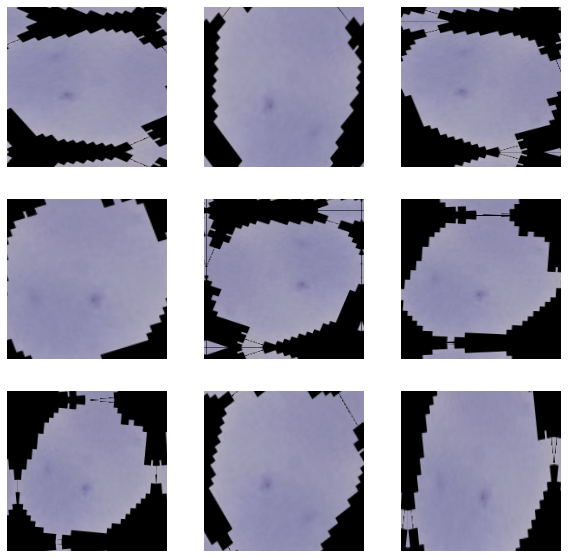

In [ ]:
img1 = train_data_generator[0][0][2]
label1 = train_data_generator[0][1][2]
if label1 == 0 : 
    print('Parasitized')
else : 
    print('Uninfected')
plt.figure(figsize=(10, 10))
first_image = img1
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

# 1.0 --> Uninfected
# 0.0 --> Infected 

# Step 3 : Building the Transfer Learning Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
# We Download the Base model of Mobilenet_V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
print('model loaded')

9412608/9406464 [==============================] - 0s 0us/step
model loaded


In [ ]:
# Here we look at the sizes of the top layer of the Model because we wish to 
# take a Global average here

image_batch, label_batch = next(iter(train_data_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(64, 5, 5, 1280)


In [ ]:
# We freeze the convolutional base to train only the added top Dense layer

base_model.trainable = False

# Let's take a look at the base model architecture
#print(base_model.summary())

In [ ]:
# Add a classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(64, 1280)


In [ ]:
# adding the prediction layer 
# to convert these features into a single prediction per image. 
# You don't need an activation function here because this prediction will be treated as 
# Positive numbers predict class 1, negative numbers predict class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(64, 1)


In [ ]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

# Step 4 : Training the Model

In [ ]:
# The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. 
# These are divided between two tf.Variable objects, the weights and biases.
len(model.trainable_variables)


2

In [ ]:
# Train the Model

initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_set)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


87/87 [==============================] - 9s 99ms/step - loss: 1.2016 - accuracy: 0.5045
initial loss: 1.20
initial accuracy: 0.50


In [ ]:
history = model.fit(train_data_generator,
                    epochs=initial_epochs,
                    validation_data=val_set)


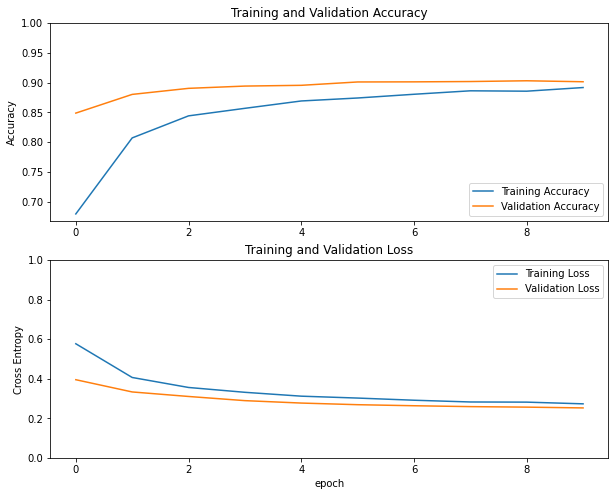

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# FINE TUNING THE Model

## Un-freeze the top layers of the model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


## Compile the new model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/60),
              metrics=['accuracy'])

#model.summary()

print('No of trainable variables in the new model:',len(model.trainable_variables))

Number of layers in the base model:  155
No of trainable variables in the new model: 58


In [ ]:
# Continue training the model

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_set)


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

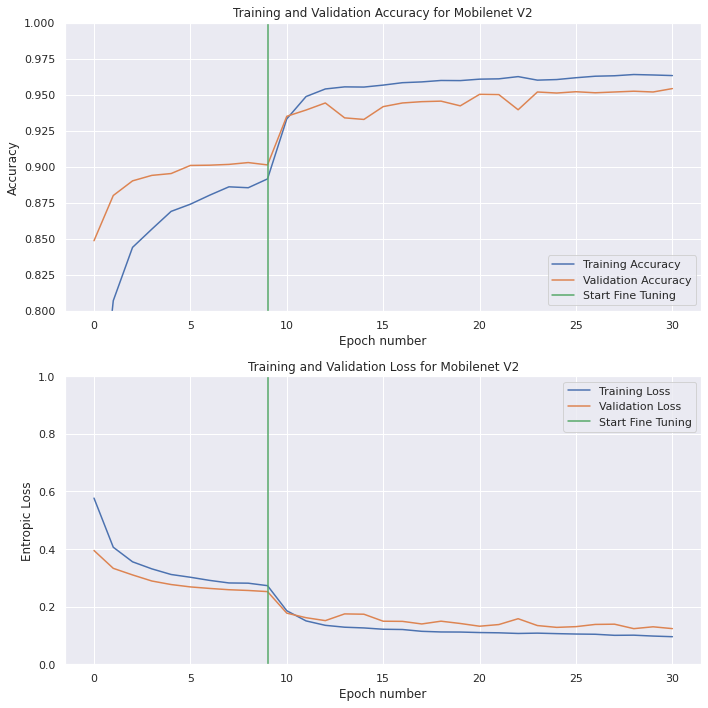

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc[:31], label='Training Accuracy')
plt.plot(val_acc[:31], label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('Epoch number' )
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Mobilenet V2')

plt.subplot(2, 1, 2)
plt.plot(loss[:31], label='Training Loss')
plt.plot(val_loss[:31], label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for Mobilenet V2')
plt.xlabel('Epoch number')
plt.ylabel('Entropic Loss')

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/My Drive/DS-Python-notebooks/My-Projects/Malaria/MobileNet_v2_val_acc_9545_oct23_1800.h5')

In [ ]:
path = '/content/drive/My Drive/DS-Python-notebooks/My-Projects/Malaria/MobileNet_v2_val_acc_9545_oct23_1800.json'

with open(path,'w') as rf:
    rf.write(model.to_json())
